In [1]:
# Import libraries
from collections import Counter, OrderedDict
from itertools import chain
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 15
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 1000
import random
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

/Users/florencialeoni/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [29]:
# Path to file
hotels_path = "../data/hotels_items.csv"
# Create dataframe
hotels_df = pd.read_csv(hotels_path, usecols = ["item_id", "properties", "city", "price"])

In [30]:
hotels_df.head()

,item_id,properties,city,price
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosmetic Mirror|Safe (Hotel)|Telephone|Hotel|Sitting Area (Rooms)|Reception (24/7)|Air Conditioning|Hypoallergenic Rooms|Cable TV|Hotel Bar|Pool Table|Bathtub|Satisfactory Rating|Room Service|Luxury Hotel|Terrace (Hotel)|Television|Minigolf|Business Hotel|Shower|Cot|Gym|Hairdryer|Hypoallergenic Bedding|Accessible Parking|From 3 Stars|Good Rating|Radio|4 Star|From 4 Stars|Family Friendly|Desk|Tennis Court (Indoor)|Balcony|WiFi (Public Areas)|Openable Windows|Express Check-In / Check-Out|Restaurant|Laundry Service|Ironing Board|Tennis Court|From 2 Stars|Business Centre|Bowling|Conference Rooms|Electric Kettle|Accessible Hotel|Porter|Bike Rental|Non-Smoking Rooms|Car Park|Safe (Rooms)|Fitness|Fan|Flatscreen TV|Computer with Internet|WiFi (Rooms)|Lift|Central Heating,"Mutterstadt, Germany",85.0
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Telephone|Hotel|Sitting Area (Rooms)|Reception (24/7)|Wheelchair Accessible|Hypoallergenic Rooms|Hotel Bar|Bathtub|Satisfactory Rating|Luxury Hotel|Terrace (Hotel)|Very Good Rating|Television|Business Hotel|Shower|Cot|Hairdryer|From 3 Stars|Good Rating|Radio|4 Star|From 4 Stars|Family Friendly|Desk|WiFi (Public Areas)|Openable Windows|Spa (Wellness Facility)|Laundry Service|Free WiFi (Combined)|From 2 Stars|Conference Rooms|Sauna|Bike Rental|Free WiFi (Rooms)|Non-Smoking Rooms|Car Park|Flatscreen TV|Excellent Rating|Computer with Internet|Pet Friendly|WiFi (Rooms)|Free WiFi (Public Areas)|Lift,"Passau, Germany",106.0
2,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone|Hotel|Cable TV|Hotel Bar|Bathtub|Satisfactory Rating|Room Service|Luxury Hotel|Terrace (Hotel)|Television|Business Hotel|Shower|From 3 Stars|Good Rating|Radio|4 Star|From 4 Stars|Family Friendly|Tennis Court (Indoor)|WiFi (Public Areas)|Openable Windows|Restaurant|Laundry Service|Free WiFi (Combined)|Tennis Court|From 2 Stars|Solarium|Conference Rooms|Bike Rental|Non-Smoking Rooms|Car Park|Concierge|Safe (Rooms)|Computer with Internet|Pet Friendly|Free WiFi (Public Areas)|Lift|Central Heating,"Hamburg, Germany",114.0
3,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Safe (Hotel)|Telephone|Hotel|Sitting Area (Rooms)|Reception (24/7)|Wheelchair Accessible|Hypoallergenic Rooms|Cable TV|Massage|Hotel Bar|Pool Table|Bathtub|Satisfactory Rating|Room Service|Luxury Hotel|Terrace (Hotel)|Towels|Television|Business Hotel|Shower|Steam Room|Spa Hotel|Swimming Pool (Outdoor)|Cot|Gym|Hairdryer|Beach|Hypoallergenic Bedding|Beauty Salon|Accessible Parking|From 3 Stars|Convention Hotel|Good Rating|Radio|4 Star|From 4 Stars|Table Tennis|Family Friendly|Desk|Tennis Court (Indoor)|Balcony|WiFi (Public Areas)|Surfing|Hot Stone Massage|Openable Windows|Spa (Wellness Facility)|Restaurant|Laundry Service|Ironing Board|Free WiFi (Combined)|Tennis Court|Romantic|Boat Rental|From 2 Stars|Business Centre|Solarium|Bowling|Conference Rooms|Sauna|Hammam|Accessible Hotel|Bike Rental|Free WiFi (Rooms)|Non-Smoking Rooms|Playground|Car Park|Safe (Rooms)|Fitness|Swimming Pool (Indoor)|Jacuzzi (Hotel)|Flatscreen TV|Honeymoon|Body Treat...,"Stralsund, Germany",114.0
4,6094,Satellite TV|Sailing|Safe (Hotel)|Telephone|Hotel|Hotel Bar|Bathtub|Satisfactory Rating|Luxury Hotel|Television|Minigolf|Business Hotel|Shower|Hairdryer|Good Rating|Radio|Desk|Tennis Court (Indoor)|WiFi (Public Areas)|Horse Riding|Openable Windows|Laundry Service|Tennis Court|3 Star|Non-Smoking Rooms|Car Park|Safe (Rooms)|Computer with Internet|WiFi (Rooms)|Central Heating,"Wolfsburg, Germany",108.0


In [32]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727491 entries, 0 to 727490
Data columns (total 4 columns):
item_id       727491 non-null int64
properties    727491 non-null object
city          727491 non-null object
price         727491 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 22.2+ MB


In [33]:
# Create item list
item_list = hotels_df["item_id"].tolist()

# Create indexes for each item
item_index = {item: idx for idx, item in enumerate(item_list)}
index_item = {idx: item for item, idx in item_index.items()}

# Create price list
price_list = hotels_df["price"].tolist()
unique_prices = set(price_list)

# Create indexes for each item
price_index = {price: idx for idx, price in enumerate(unique_prices)}
index_price = {idx: price for price, idx in price_index.items()}

# Prepare properties column

# Split of pipe
hotels_df["properties"] = hotels_df["properties"].str.split("|")

# Convert all properties to lowercase
hotels_df["properties"] = hotels_df["properties"].apply(lambda x: [w.lower() for w in x])

# Create list
properties_list = hotels_df["properties"].tolist()

# Find set of unique properties and convert to a list
unique_properties = list(chain(*[list(set(tags)) for tags in properties_list]))
unique_properties = set(unique_properties)

# Create indexes for each property
property_index = {tag: idx for idx, tag in enumerate(unique_properties)}
index_properties = {idx: tag for tag, idx in property_index.items()}

# Prepare city column

# Convert all properties to lowercase
hotels_df["city"] = hotels_df["city"].apply(lambda x: x.lower())

# Create list
location_list = hotels_df["city"].tolist()

# Find set of unique locations and convert to a list
# unique_locations = list(chain(*[list(set(location)) for location in location_list]))
unique_locations = set(location_list)

# Create indexes for each property
location_index = {location: idx for idx, location in enumerate(unique_locations)}
index_location = {idx: location for location, idx in location_index.items()}

In [34]:
# Import embeddings model and weights
embeddings_model = models.load_model("../models/embeddings_third_attempt.h5")
embeddings_model.load_weights("../models/embeddings_third_attempt_weights.h5")

In [35]:
# Extract embeddings
hotel_layer = embeddings_model.get_layer("item_embedding")
hotel_weights = hotel_layer.get_weights()[0]
properties_layer = embeddings_model.get_layer("property_embedding")
properties_weights = properties_layer.get_weights()[0]
price_layer = embeddings_model.get_layer("price_embedding")
price_weights = price_layer.get_weights()[0]
location_layer = embeddings_model.get_layer("location_embedding")
location_weights = location_layer.get_weights()[0]

# Normalize the embeddings so that we can calculate cosine similarity
hotel_weights = hotel_weights / np.linalg.norm(hotel_weights, axis = 1).reshape((-1, 1))
properties_weights = properties_weights / np.linalg.norm(properties_weights, axis = 1).reshape((-1, 1))
price_weights = price_weights / np.linalg.norm(price_weights, axis = 1).reshape((-1, 1))
location_weights = location_weights / np.linalg.norm(location_weights, axis =1 ).reshape((-1, 1))

In [78]:
# Finding similar hotels
def find_similar_hotels(name, weights, index_name = "item", n = 5, return_dist = False, plot = False):
    
    # Select index and reverse index
    if index_name == "item":
        index = item_index
        rindex = index_item
    if index_name == "property":
        index = property_index
        rindex = index_properties
    if index_name == "price":
        index = price_index
        rindex = index_price
    if index_name == "location":
        index = location_index
        rindex = index_location
        
    # Check name is in index
    try:
        # Calculate dot product between item/property and all others
        distances = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f"{name} Not Found.")
        return
    
    # Sort distances from smallest to largest
    sorted_distances = np.argsort(distances)

    # Plot results if True
    if plot:
        # Find closest and most far away item
        far_away = sorted_distances[:n // 2]
        closest = sorted_distances[-n-1: len(distances) - 1]
        to_plot = [rindex[c] for c in far_away]
        to_plot.extend(rindex[c] for c in closest)
        
        # Find distances 
        dist = [distances[c] for c in far_away]
        dist.extend(distances[c] for c in closest)
        
        # Colors
        colors = ["hotpink" for _ in range(n // 2)]
        colors.extend("darkturquoise" for _ in range(n))
        
        # Data in DataFrame
        data = pd.DataFrame({"distance": dist}, index = to_plot)
        
        # Bar chart
        data["distance"].plot.barh(color = colors, figsize = (10, 8), edgecolor = "k", linewidth = 2)
        plt.xlabel("Cosine Similarity");
        plt.axvline(x = 0, color = "k");
        
        # Title
        name_str = f"Most and Least Similar to {name}"
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # Find the most similar
    closest = sorted_distances[-n:]

    # If return_dist True
    if return_dist:
        return distances, closest
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f"{index_name}: {rindex[c]} Similarity: {distances[c]:.{2}}")


In [79]:
find_similar_hotels(6066, hotel_weights)

item: 6066 Similarity: 1.0
item: 480456 Similarity: 0.49
item: 9728018 Similarity: 0.45
item: 4051786 Similarity: 0.44
item: 9464382 Similarity: 0.43


In [81]:
find_similar_hotels(114, price_weights, index_name = "price")

price: 114.0 Similarity: 1.0
price: 3138.0 Similarity: 0.37
price: 4247.0 Similarity: 0.37
price: 1234.0 Similarity: 0.36
price: 405.0 Similarity: 0.32


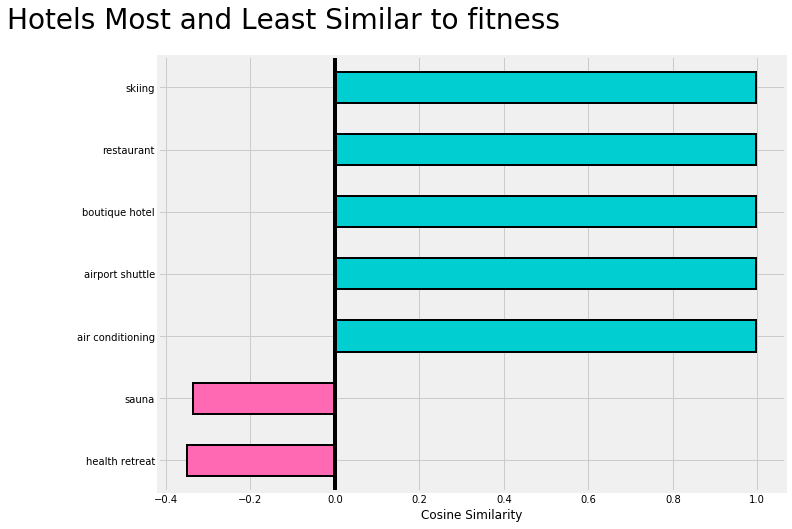

In [41]:
find_similar_hotels("fitness", properties_weights, index_name = "property", plot = True)

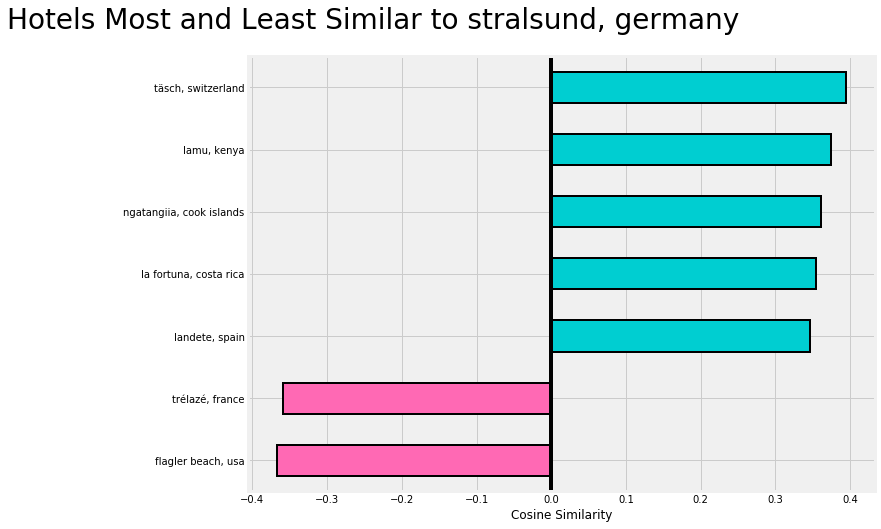

In [45]:
find_similar_hotels("stralsund, germany", location_weights, index_name = "location", plot = True)

In [47]:
# Reduce hotels
hotels_reduced = TSNE(n_components = 2, metric = "cosine", verbose = 2).fit_transform(hotel_weights)
hotels_reduced.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 727491 samples in 0.056s...
[t-SNE] Computed neighbors for 727491 samples in 11078.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 727491
[t-SNE] Computed conditional probabilities for sample 2000 / 727491
[t-SNE] Computed conditional probabilities for sample 3000 / 727491
[t-SNE] Computed conditional probabilities for sample 4000 / 727491
[t-SNE] Computed conditional probabilities for sample 5000 / 727491
[t-SNE] Computed conditional probabilities for sample 6000 / 727491
[t-SNE] Computed conditional probabilities for sample 7000 / 727491
[t-SNE] Computed conditional probabilities for sample 8000 / 727491
[t-SNE] Computed conditional probabilities for sample 9000 / 727491
[t-SNE] Computed conditional probabilities for sample 10000 / 727491
[t-SNE] Computed conditional probabilities for sample 11000 / 727491
[t-SNE] Computed conditional probabilities for sample 12000 / 727491
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 118000 / 727491
[t-SNE] Computed conditional probabilities for sample 119000 / 727491
[t-SNE] Computed conditional probabilities for sample 120000 / 727491
[t-SNE] Computed conditional probabilities for sample 121000 / 727491
[t-SNE] Computed conditional probabilities for sample 122000 / 727491
[t-SNE] Computed conditional probabilities for sample 123000 / 727491
[t-SNE] Computed conditional probabilities for sample 124000 / 727491
[t-SNE] Computed conditional probabilities for sample 125000 / 727491
[t-SNE] Computed conditional probabilities for sample 126000 / 727491
[t-SNE] Computed conditional probabilities for sample 127000 / 727491
[t-SNE] Computed conditional probabilities for sample 128000 / 727491
[t-SNE] Computed conditional probabilities for sample 129000 / 727491
[t-SNE] Computed conditional probabilities for sample 130000 / 727491
[t-SNE] Computed conditional probabilities for sample 131000 / 727491
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 241000 / 727491
[t-SNE] Computed conditional probabilities for sample 242000 / 727491
[t-SNE] Computed conditional probabilities for sample 243000 / 727491
[t-SNE] Computed conditional probabilities for sample 244000 / 727491
[t-SNE] Computed conditional probabilities for sample 245000 / 727491
[t-SNE] Computed conditional probabilities for sample 246000 / 727491
[t-SNE] Computed conditional probabilities for sample 247000 / 727491
[t-SNE] Computed conditional probabilities for sample 248000 / 727491
[t-SNE] Computed conditional probabilities for sample 249000 / 727491
[t-SNE] Computed conditional probabilities for sample 250000 / 727491
[t-SNE] Computed conditional probabilities for sample 251000 / 727491
[t-SNE] Computed conditional probabilities for sample 252000 / 727491
[t-SNE] Computed conditional probabilities for sample 253000 / 727491
[t-SNE] Computed conditional probabilities for sample 254000 / 727491
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 365000 / 727491
[t-SNE] Computed conditional probabilities for sample 366000 / 727491
[t-SNE] Computed conditional probabilities for sample 367000 / 727491
[t-SNE] Computed conditional probabilities for sample 368000 / 727491
[t-SNE] Computed conditional probabilities for sample 369000 / 727491
[t-SNE] Computed conditional probabilities for sample 370000 / 727491
[t-SNE] Computed conditional probabilities for sample 371000 / 727491
[t-SNE] Computed conditional probabilities for sample 372000 / 727491
[t-SNE] Computed conditional probabilities for sample 373000 / 727491
[t-SNE] Computed conditional probabilities for sample 374000 / 727491
[t-SNE] Computed conditional probabilities for sample 375000 / 727491
[t-SNE] Computed conditional probabilities for sample 376000 / 727491
[t-SNE] Computed conditional probabilities for sample 377000 / 727491
[t-SNE] Computed conditional probabilities for sample 378000 / 727491
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 488000 / 727491
[t-SNE] Computed conditional probabilities for sample 489000 / 727491
[t-SNE] Computed conditional probabilities for sample 490000 / 727491
[t-SNE] Computed conditional probabilities for sample 491000 / 727491
[t-SNE] Computed conditional probabilities for sample 492000 / 727491
[t-SNE] Computed conditional probabilities for sample 493000 / 727491
[t-SNE] Computed conditional probabilities for sample 494000 / 727491
[t-SNE] Computed conditional probabilities for sample 495000 / 727491
[t-SNE] Computed conditional probabilities for sample 496000 / 727491
[t-SNE] Computed conditional probabilities for sample 497000 / 727491
[t-SNE] Computed conditional probabilities for sample 498000 / 727491
[t-SNE] Computed conditional probabilities for sample 499000 / 727491
[t-SNE] Computed conditional probabilities for sample 500000 / 727491
[t-SNE] Computed conditional probabilities for sample 501000 / 727491
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 615000 / 727491
[t-SNE] Computed conditional probabilities for sample 616000 / 727491
[t-SNE] Computed conditional probabilities for sample 617000 / 727491
[t-SNE] Computed conditional probabilities for sample 618000 / 727491
[t-SNE] Computed conditional probabilities for sample 619000 / 727491
[t-SNE] Computed conditional probabilities for sample 620000 / 727491
[t-SNE] Computed conditional probabilities for sample 621000 / 727491
[t-SNE] Computed conditional probabilities for sample 622000 / 727491
[t-SNE] Computed conditional probabilities for sample 623000 / 727491
[t-SNE] Computed conditional probabilities for sample 624000 / 727491
[t-SNE] Computed conditional probabilities for sample 625000 / 727491
[t-SNE] Computed conditional probabilities for sample 626000 / 727491
[t-SNE] Computed conditional probabilities for sample 627000 / 727491
[t-SNE] Computed conditional probabilities for sample 628000 / 727491
[t-SNE] Computed con

[t-SNE] Iteration 100: error = 8.0296059, gradient norm = 0.0000000 (50 iterations in 1045.935s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations: 8.029606


(727491, 2)

In [48]:
# Reduce properties
properties_reduced = TSNE(n_components = 2, metric = "cosine", verbose = 2).fit_transform(properties_weights)
properties_reduced.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 157 samples in 0.001s...
[t-SNE] Computed neighbors for 157 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 157 / 157
[t-SNE] Mean sigma: 0.159250
[t-SNE] Computed conditional probabilities in 0.006s
[t-SNE] Iteration 50: error = 59.3130417, gradient norm = 0.4957039 (50 iterations in 0.036s)
[t-SNE] Iteration 100: error = 58.5004539, gradient norm = 0.5460085 (50 iterations in 0.034s)
[t-SNE] Iteration 150: error = 61.5748215, gradient norm = 0.4812677 (50 iterations in 0.036s)
[t-SNE] Iteration 200: error = 57.0899315, gradient norm = 0.5389248 (50 iterations in 0.037s)
[t-SNE] Iteration 250: error = 59.0759010, gradient norm = 0.4772651 (50 iterations in 0.037s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.075901
[t-SNE] Iteration 300: error = 0.9335469, gradient norm = 0.0090204 (50 iterations in 0.033s)
[t-SNE] Iteration 350: error = 0.7186636, gradient norm = 0.0032329 (

(157, 2)

In [50]:
# Reduce price
price_reduced = TSNE(n_components = 2, metric = "cosine", verbose = 2).fit_transform(price_weights)
price_reduced.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2834 samples in 0.000s...
[t-SNE] Computed neighbors for 2834 samples in 0.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2834
[t-SNE] Computed conditional probabilities for sample 2000 / 2834
[t-SNE] Computed conditional probabilities for sample 2834 / 2834
[t-SNE] Mean sigma: 0.175646
[t-SNE] Computed conditional probabilities in 0.087s
[t-SNE] Iteration 50: error = 83.9583359, gradient norm = 0.0000001 (50 iterations in 1.120s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.958336
[t-SNE] Iteration 100: error = 4.0750694, gradient norm = 0.0016173 (50 iterations in 0.990s)
[t-SNE] Iteration 150: error = 3.9187007, gradient norm = 0.0006548 (50 iterations in 0.829s)
[t-SNE] Iteration 200: error = 3.8044972, gradient norm = 0.0004019 (50 iterations in 0.796s)
[t-SNE] Iteration 250: error = 3.7300127, gradient norm = 0.0002509 (5

(2834, 2)

In [62]:
# Reduce location
location_reduced = TSNE(n_components = 2, metric = "cosine", verbose = 3, perplexity = 40, 
                       learning_rate = 10, n_iter = 5000).fit_transform(location_weights)
location_reduced.shape

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 27194 samples in 0.003s...
[t-SNE] Computed neighbors for 27194 samples in 13.853s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27194
[t-SNE] Computed conditional probabilities for sample 2000 / 27194
[t-SNE] Computed conditional probabilities for sample 3000 / 27194
[t-SNE] Computed conditional probabilities for sample 4000 / 27194
[t-SNE] Computed conditional probabilities for sample 5000 / 27194
[t-SNE] Computed conditional probabilities for sample 6000 / 27194
[t-SNE] Computed conditional probabilities for sample 7000 / 27194
[t-SNE] Computed conditional probabilities for sample 8000 / 27194
[t-SNE] Computed conditional probabilities for sample 9000 / 27194
[t-SNE] Computed conditional probabilities for sample 10000 / 27194
[t-SNE] Computed conditional probabilities for sample 11000 / 27194
[t-SNE] Computed conditional probabilities for sample 12000 / 27194
[t-SNE] Computed conditional probabilities for s

(27194, 2)

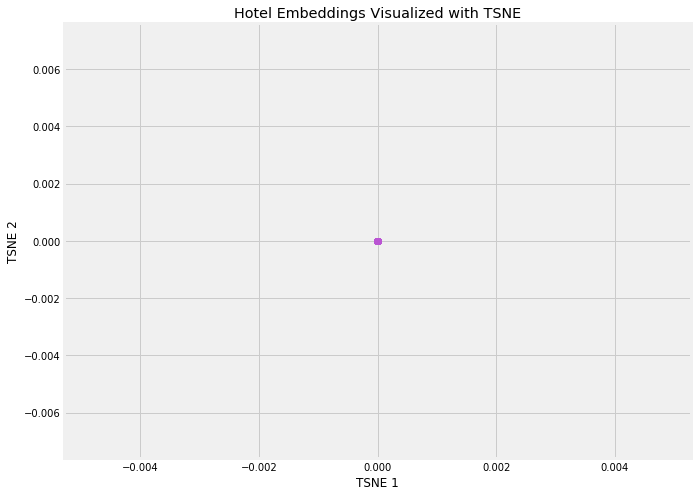

In [52]:
# Plot reduced hotels
plt.figure(figsize = (10, 8))
plt.scatter(hotels_reduced[:, 0], hotels_reduced[:, 1], c = "mediumorchid")
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Hotel Embeddings Visualized with TSNE");

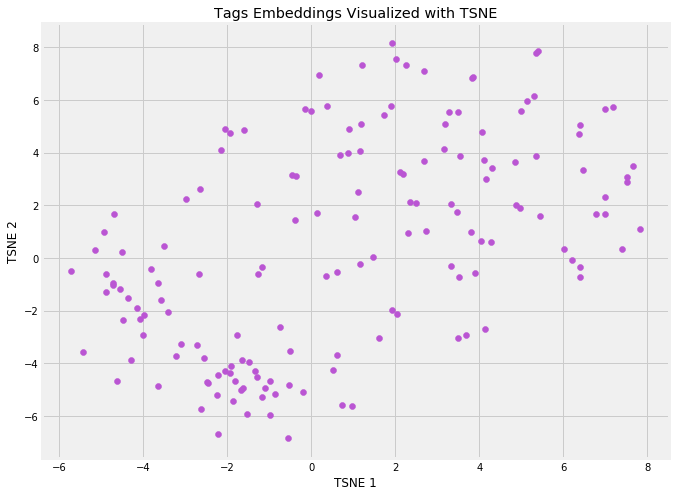

In [53]:
# Plot reduced properties
plt.figure(figsize = (10, 8))
plt.scatter(properties_reduced[:, 0], properties_reduced[:, 1], c = "mediumorchid")
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Tags Embeddings Visualized with TSNE");

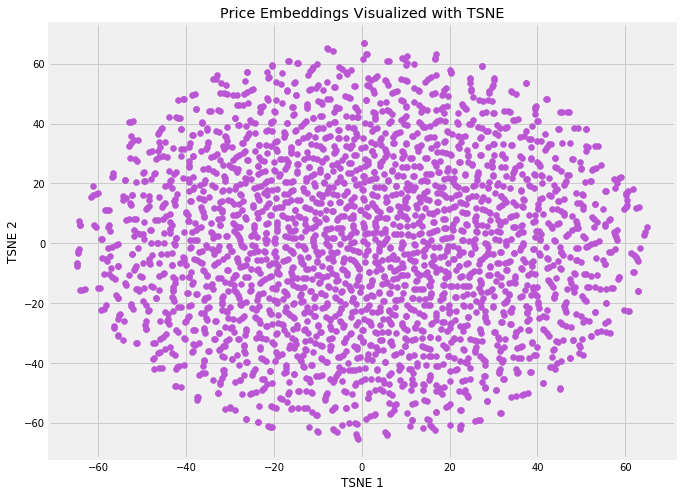

In [54]:
# Plot reduced prices
plt.figure(figsize = (10, 8))
plt.scatter(price_reduced[:, 0], price_reduced[:, 1], c = "mediumorchid")
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Price Embeddings Visualized with TSNE");

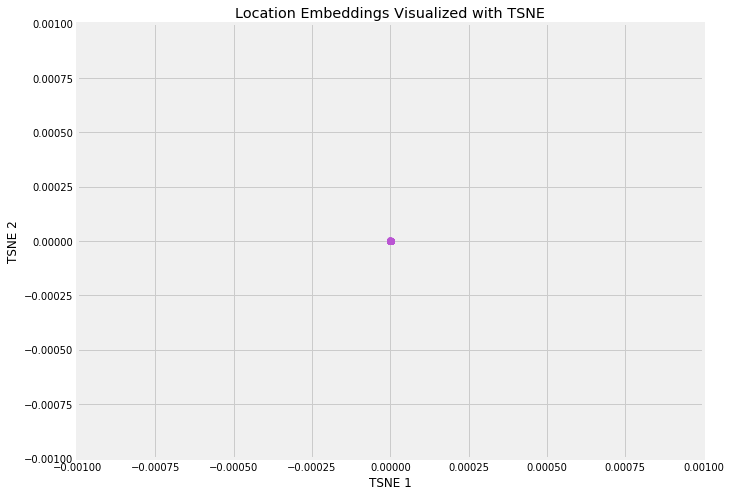

In [63]:
# Plot reduced locations
plt.figure(figsize = (10, 8))
plt.scatter(location_reduced[:, 0], location_reduced[:, 1], c = "mediumorchid")
plt.xlim(-0.001, 0.001); plt.ylim(-0.001, 0.001)
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Location Embeddings Visualized with TSNE");